<a href="https://colab.research.google.com/github/Armaan-Raina/Schizophrenia-EEG-Classification/blob/main/Schizophrenia_EEG_Classification_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processing/ classifying EEG using ML**


# This project uses a dataset containing EEG data from healthy and schizophrenic individuals, we will create a system to classify the data.

## **Import data onto colab**

In [ ]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas
import seaborn as sns

In [ ]:
%%capture
!pip install mne

In [ ]:
import mne
from mne.preprocessing import ICA

In [ ]:
raw_all_files = glob('EEG/*.edf')
raw_all_files.sort()
raw_healthy_files = [file for file in raw_all_files if 'h' in file]
raw_healthy_files.sort()
raw_patient_files = [file for file in raw_all_files if 's' in file]
raw_patient_files.sort()

In [ ]:
len(raw_all_files)

28

## **Read the EEG data**

In [ ]:
def read_data(filepath:str):
  data = mne.io.read_raw_edf(filepath, preload=True)
  data.set_eeg_reference()
  data.filter(l_freq = 0.5, h_freq = 45)
  return data

In [ ]:
%%capture
all_files = [read_data(i) for i in raw_all_files]
healthy_files = [read_data(i) for i in raw_healthy_files]
patient_files = [read_data(i) for i in raw_patient_files]

## **Perform ICA to reduce unnecessary noise**

In [ ]:
num_channels = all_files[0].info['nchan']

In [ ]:
num_channels

19

In [ ]:
%%capture
clean_data = []

for file in all_files: #iterate through each file and apply ICA

  copy = file.copy()
  ica = ICA(n_components = num_channels, random_state=97, max_iter=800)

  ica.fit(copy)

  ica.apply(copy)

  clean_data.append(copy)

In [ ]:
clean_healthy_files = clean_data[:len(healthy_files)]
clean_patient_files = clean_data[len(healthy_files):]

### **Visualize Cleaned Data**

Using matplotlib as 2D backend.


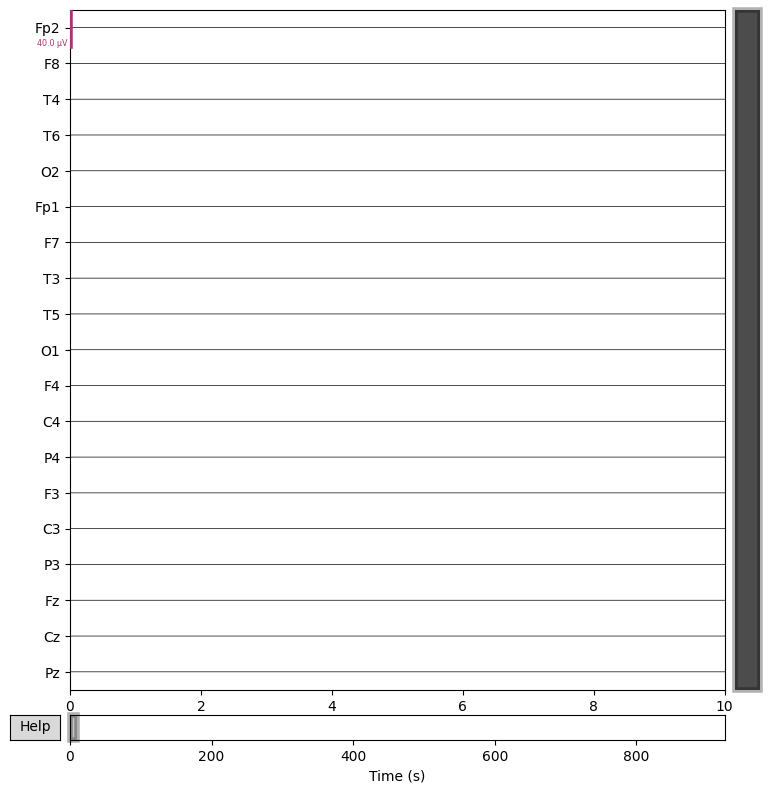

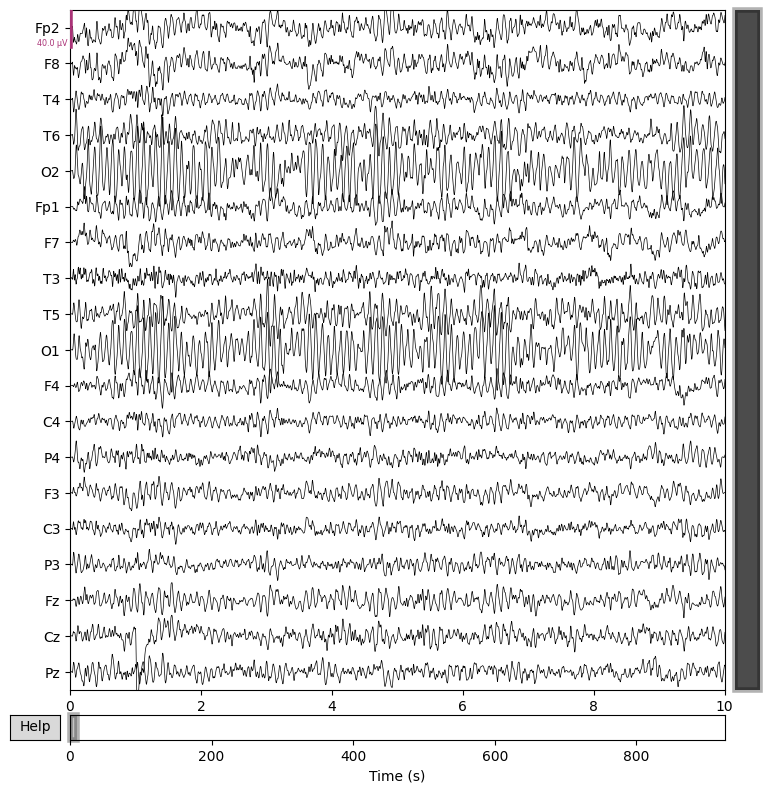

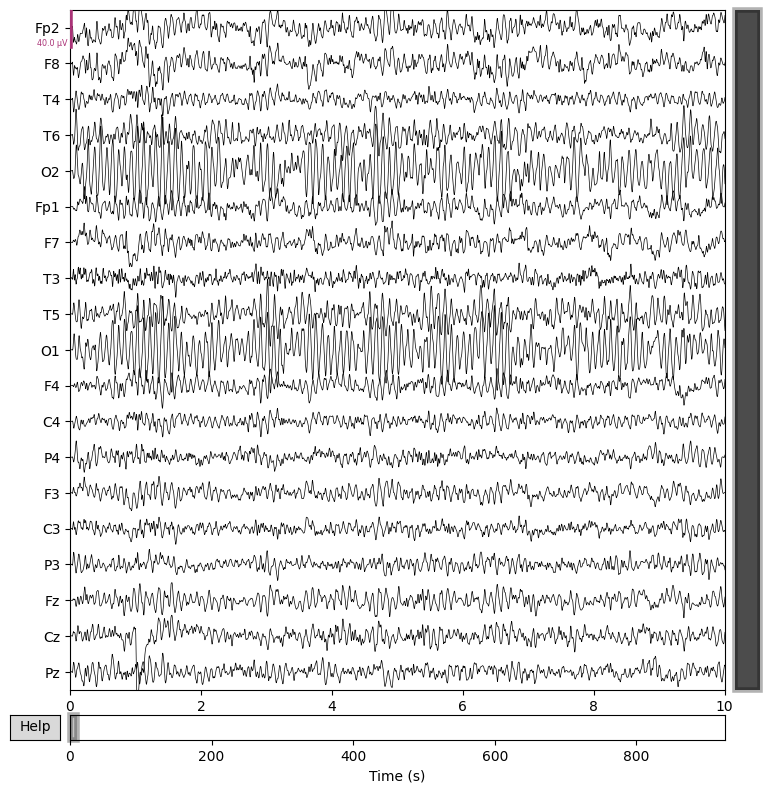

In [ ]:
clean_healthy_files[0].plot()
healthy_files[0].plot()

## **Transform data into more accessible format**

In [ ]:
def make_epochs(filepath):
  epochs = mne.make_fixed_length_epochs(filepath, duration=5, overlap=1)
  return epochs

In [ ]:
%%capture
epoched_healthy_files = [make_epochs(i) for i in healthy_files]
epoched_patient_files = [make_epochs(i) for i in patient_files]

In [ ]:
print(dir(mne.time_frequency))

['AverageTFR', 'AverageTFRArray', 'BaseTFR', 'CrossSpectralDensity', 'EpochsSpectrum', 'EpochsSpectrumArray', 'EpochsTFR', 'EpochsTFRArray', 'RawTFR', 'RawTFRArray', 'Spectrum', 'SpectrumArray', 'csd_array_fourier', 'csd_array_morlet', 'csd_array_multitaper', 'csd_fourier', 'csd_morlet', 'csd_multitaper', 'csd_tfr', 'dpss_windows', 'fit_iir_model_raw', 'fwhm', 'istft', 'morlet', 'pick_channels_csd', 'psd_array_multitaper', 'psd_array_welch', 'read_csd', 'read_spectrum', 'read_tfrs', 'stft', 'stftfreq', 'tfr_array_morlet', 'tfr_array_multitaper', 'tfr_array_stockwell', 'tfr_morlet', 'tfr_multitaper', 'tfr_stockwell', 'write_tfrs']


## **Feature Extraction**

In [ ]:
def extract_band_power(epochs, bands:dict):

    data = epochs.get_data()  # n_epochs, n_channels, n_times


    psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=epochs.info['sfreq'], fmin=1, fmax=40, n_fft=256)

    #psd is a 3d array (n_epochs, n_channels, n_freq)
    #freqs is a 1d array of frequencies with length corresponding to n_freq

    band_powers = {}
    for band, (fmin, fmax) in bands.items(): #iterate through the different EEG frequency bands
        indices = np.logical_and(freqs >= fmin, freqs <= fmax) #only the indicies in Hz range
        band_powers[band] = np.mean(psd[:, :, indices], axis=2) #average over the specific frequency band

    return band_powers

In [ ]:
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 40)
}
# initialize the bands and their frequencies

In [ ]:
%%capture
healthy_band_powers = [extract_band_power(i, bands) for i in epoched_healthy_files]
patient_band_powers = [extract_band_power(i, bands) for i in epoched_patient_files]

In [ ]:
def convert_band_powers_to_features(band_powers_list):
    features_list = []
    for band_powers in band_powers_list:
        feature_matrix = []
        for band, power_array in band_powers.items():
            feature_matrix.append(power_array.reshape(power_array.shape[0], -1))
        features_list.append(np.hstack(feature_matrix))  # Combine all band features into a single matrix
    return np.vstack(features_list)  # Combine matrices for all files

In [ ]:
# Convert dictionaries to feature matrices
X_healthy = convert_band_powers_to_features(healthy_band_powers)
X_patient = convert_band_powers_to_features(patient_band_powers)

# Create labels (0 for healthy, 1 for schizophrenic)
y_healthy = np.zeros(X_healthy.shape[0])
y_patient = np.ones(X_patient.shape[0])

# Combine data and labels
X = np.vstack([X_healthy, X_patient])
y = np.hstack([y_healthy, y_patient])

In [ ]:
X.shape

(7201, 95)

In [ ]:
y.shape

(7201,)

## **Data Visualization**

In [ ]:
def vis_data_waves(filepath:str, epochs:bool, e_idx=None, c_idx=None):
  vis = mne.io.read_raw_edf(filepath, preload=True)
  if epochs: #To visualize each individual epoch
    vis.set_eeg_reference()
    vis.filter(l_freq=0.5, h_freq=45)
    vis_epochs = mne.make_fixed_length_epochs(vis, duration=5, overlap=1)
    data = vis_epochs.get_data()
    plt.plot(data[e_idx, c_idx, :])
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (mA)")
    c_name = vis_epochs.ch_names[c_idx]
    plt.title(f"EEG data from epoch {e_idx} recorded from the {c_name} channel")
    plt.show()
  else:
    vis.plot()
  plt.show()

Extracting EDF parameters from /content/EEG/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...


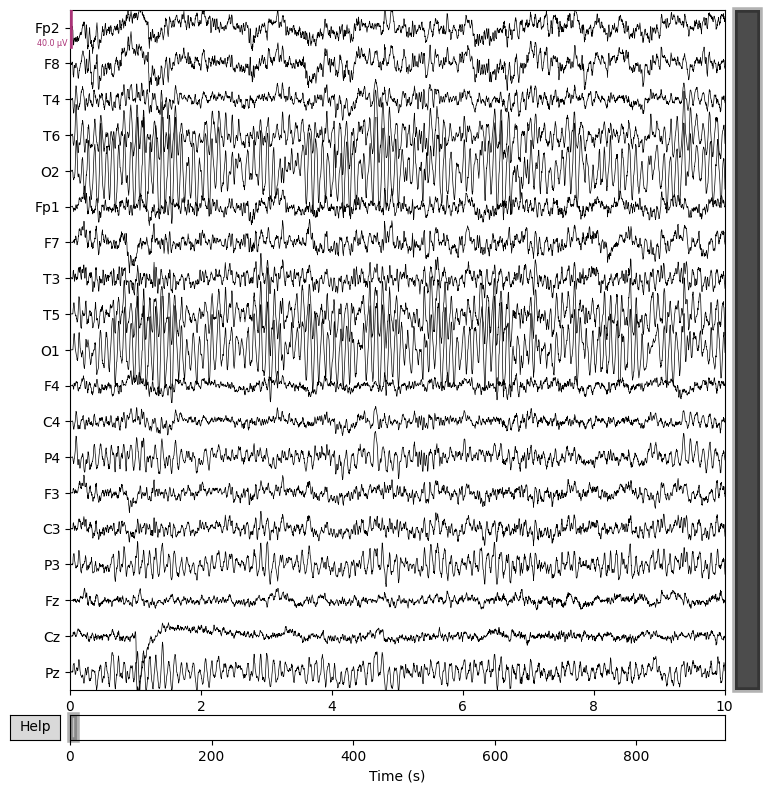

In [ ]:
vis_data_waves(raw_healthy_files[0], False)

Extracting EDF parameters from /content/EEG/s01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 211249  =      0.000 ...   844.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
211 matching events found
No baseline correction applied
0 projection items activated
Using data from preload

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


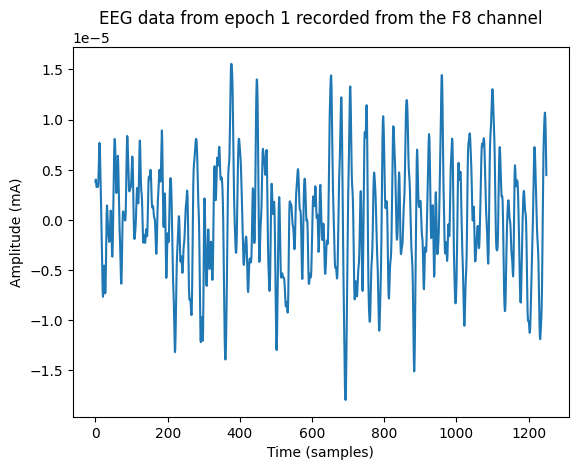

In [ ]:
vis_data_waves(raw_patient_files[0], True, 1,1)

In [ ]:
def vis_topmap(filepath):
  map = mne.io.read_raw_edf(filepath, preload=True)
  map.set_eeg_reference()
  map.filter(l_freq=0.5, h_freq=45)

  montage = mne.channels.make_standard_montage('standard_1005')
  map.set_montage(montage)
  epochs = mne.make_fixed_length_epochs(map, duration=5, overlap=1)
  evoked = epochs.average()
  evoked.plot_topomap(times=np.linspace(0.05, 0.25, 5), ch_type='eeg', show_names=True)
  plt.show()

Extracting EDF parameters from /content/EEG/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
231 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


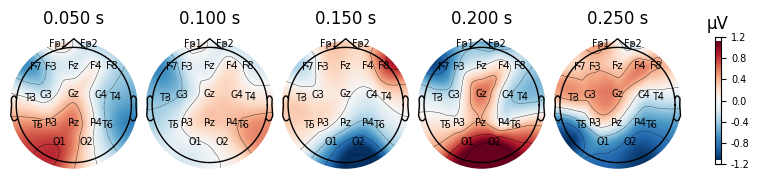

In [ ]:
vis_topmap(raw_healthy_files[0])

In [ ]:
def plot_psd(filepath):
  psd = mne.io.read_raw_edf(filepath, preload=True)
  psd.set_eeg_reference()
  psd.filter(l_freq=0.5, h_freq=45)
  fig = psd.plot_psd()

  ax = fig.axes[0]
  lines = ax.get_lines()
  for line, color in zip(lines, plt.cm.plasma(np.linspace(0, 1, len(lines)))):
      line.set_color(color)

  plt.show()

Extracting EDF parameters from /content/EEG/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
<ipython-input-28-5e07305d4b6b>:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot_psd()


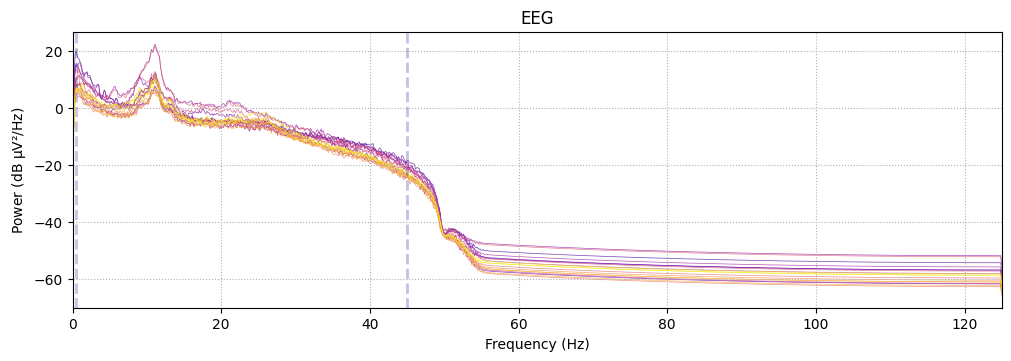

In [ ]:
plot_psd(raw_healthy_files[0])

## **Build Random Forest Classification Model**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
sc = StandardScaler()
rf = RandomForestClassifier()
pipe = Pipeline([('scaler', sc), ('model', rf)])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

In [ ]:
y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9680777238029147
